In [1]:
import torch
weights = torch.load("/mnt/rd/all_weights.pt", map_location="cpu")#.bfloat16().cuda()#.half()
V = torch.load("/mnt/rd/V.pt", map_location="cpu").cuda()#.half()
mean = torch.load("/mnt/rd/mean.pt", map_location="cpu").cuda()#.half()
std = torch.load("/mnt/rd/std.pt", map_location="cpu").cuda()#.half()
pinverse = torch.load("/mnt/rd/weights2weights/files/pinverse_1000pc.pt").cuda()
df = torch.load("/mnt/rd/weights2weights/files/identity_df.pt")#.cuda()

In [2]:
import tqdm
test_weight = weights.cuda()#.float()
batch_size = 4096
with torch.no_grad():
    # test_pca = torch.zeros(test_weight.shape[0], 10000, device="cuda")
    # reconstructed = torch.zeros(test_weight.shape[0], 99_648, device="cpu")
    # for i in tqdm.tqdm(range(0, test_weight.shape[0], batch_size)):
        # merged = lora_vae.encode( 
        #     lora_vae.apply_std_on_weights(test_weight[i:i+batch_size].float().cuda()),
        #     # mean_logvar=True#
        #       )[0]#.chunk(2, dim=-1)[0]
        # decoded_lora = lora_vae.deapply_std_on_weights(lora_vae.decode(merged))

        # merged = torch.cat([mean, logvar], dim=-1)
        # test_pca[i:i+batch_size] = merged
        # reconstructed[i:i+batch_size] = decoded_lora
    test_pca = ((test_weight - mean) / (std)) @ V

In [3]:
import os
import gc
import torch
import random
from tqdm import tqdm
import sys
sys.path.append(os.path.abspath("/home/ubuntu/AutoLoRADiscovery/discover_lora_diffusion/weights2weights"))
from editing import get_direction, edit_inference, debias


# Define attribute sets with their corresponding strengths
attribute_sets = {
    500_000: {
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bangs', 
        'Big_Lips', 'Big_Nose', 'Blond_Hair', 'Bushy_Eyebrows', 
        'Heavy_Makeup', 'Male', 'Mustache', 'No_Beard', 'Oval_Face', 
        'Pointy_Nose', 'Wearing_Lipstick', 'Young',
          'Black_Hair', 'Brown_Hair', 'Eyeglasses', 'Narrow_Eyes', 
        'Pale_Skin', 'Receding_Hairline', 'Straight_Hair',
            'Bald', 'Double_Chin',
        'Bags_Under_Eyes', 'Chubby', 'Goatee', 'High_Cheekbones', 
        'Rosy_Cheeks', 'Sideburns', 'Wavy_Hair',
        'Gray_Hair'
    },
}

# Create a flat list of all attributes
all_attributes = [attr for attrs in attribute_sets.values() for attr in attrs]

# Create a mapping of attributes to their strengths
attribute_to_strength = {attr: strength for strength, attrs in attribute_sets.items() for attr in attrs}

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()



def manipulate_lora(direction, lora, manipulate_type):
    strength = attribute_to_strength[manipulate_type]
    
    return lora + strength * direction



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_samples_per_lora= 10
manipulated_loras = {}
directions = {}

with torch.cuda.amp.autocast():
    global_step = 9
    for idx in tqdm(range(len(weights)), desc="Generating LoRAs for id"):
        lora_pca = test_pca[idx].unsqueeze(0)
        manipulate_types = random.choices(all_attributes, k=num_samples_per_lora)
        for i in range(num_samples_per_lora):
            manipulate_type = manipulate_types[i]
            if manipulate_type not in manipulated_loras:
                manipulated_loras[manipulate_type] = []
                directions[manipulate_type] = get_direction(df=df, label=manipulate_type, pinverse=pinverse, device=device, return_dim=10_000)
            manipulated_lora = manipulate_lora(directions[manipulate_type], lora_pca, manipulate_type).squeeze(0)
            
            manipulated_loras[manipulate_type].append(manipulated_lora)

            global_step += 1

        del lora_pca, manipulated_lora


2024-08-06 01:16:21.190837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 01:16:22.072129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Generating LoRAs for id: 100%|██████████| 64974/64974 [00:49<00:00, 1325.28it/s]


In [4]:
def unproject(lora_pca):
    return lora_pca @ V.T * std + mean

In [14]:
import os
from PIL import Image
from IPython.display import display, Image as IPImage
import io
import copy
from discover_lora_diffusion.weights2weights.lora_w2w import LoRAw2w
from discover_lora_diffusion.weights2weights.utils import unflatten
from diffusers import DiffusionPipeline , logging
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights
import torch
weight_dimensions = torch.load("/mnt/rd/weight_dimensions.pt")
device = "cuda:0"

pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                            torch_dtype=torch.float16,safety_checker = None,
                                            requires_safety_checker = False).to(device)
pipe_unet = pipe.unet                               
def generate_from_weights(weight, prompt):
    if os.path.exists("/mnt/rd/inference_lora_2"):
        os.system("rm -rf /mnt/rd/inference_lora_2")

    unflatten(weight.unsqueeze(0).detach().clone(), weight_dimensions, "/mnt/rd/inference_lora_2")
    logging.disable_progress_bar()
    

    pipe.set_progress_bar_config(disable=True)

    pipe.unet = copy.deepcopy(pipe_unet)
    pipe.unet = PeftModel.from_pretrained(pipe.unet, "/mnt/rd/inference_lora_2/unet", adapter_name="identity1")
    adapters_weights1 = load_peft_weights("/mnt/rd/inference_lora_2/unet", device="cuda:0")
    pipe.unet.load_state_dict(adapters_weights1, strict = False)
    pipe.unet.to("cuda", torch.float16)

    # torch rng 
    generator = torch.Generator(device="cuda")
    generator.manual_seed(0)
    negative_prompt = "low quality, blurry, unfinished, cartoon"
    images = pipe([prompt]*2,
                   negative_prompt=[negative_prompt]*2,
    
     height=640, width=640, num_inference_steps=50, guidance_scale=3.5, generator=generator).images
    
    canvas = Image.new('RGB', (640*2, 640))
    for i, image in enumerate(images):
        canvas.paste(image, (640*i, 0))

    # return images[0]

    # save as low res image
    imgbyte = io.BytesIO()
    canvas.save(imgbyte, format="JPEG", quality=20)
    imgbyte.seek(0)

    display(IPImage(data=imgbyte.read(), width=640*4))

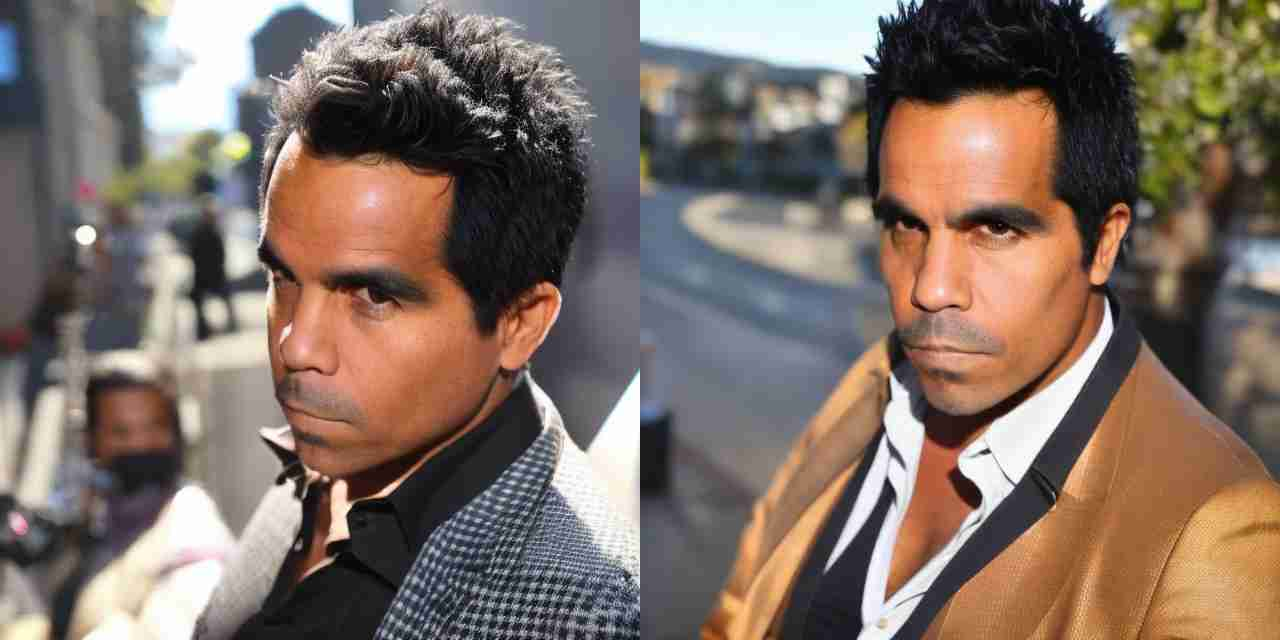

In [20]:
generate_from_weights(unproject(manipulated_loras["Black_Hair"][0]), prompt="sks person")

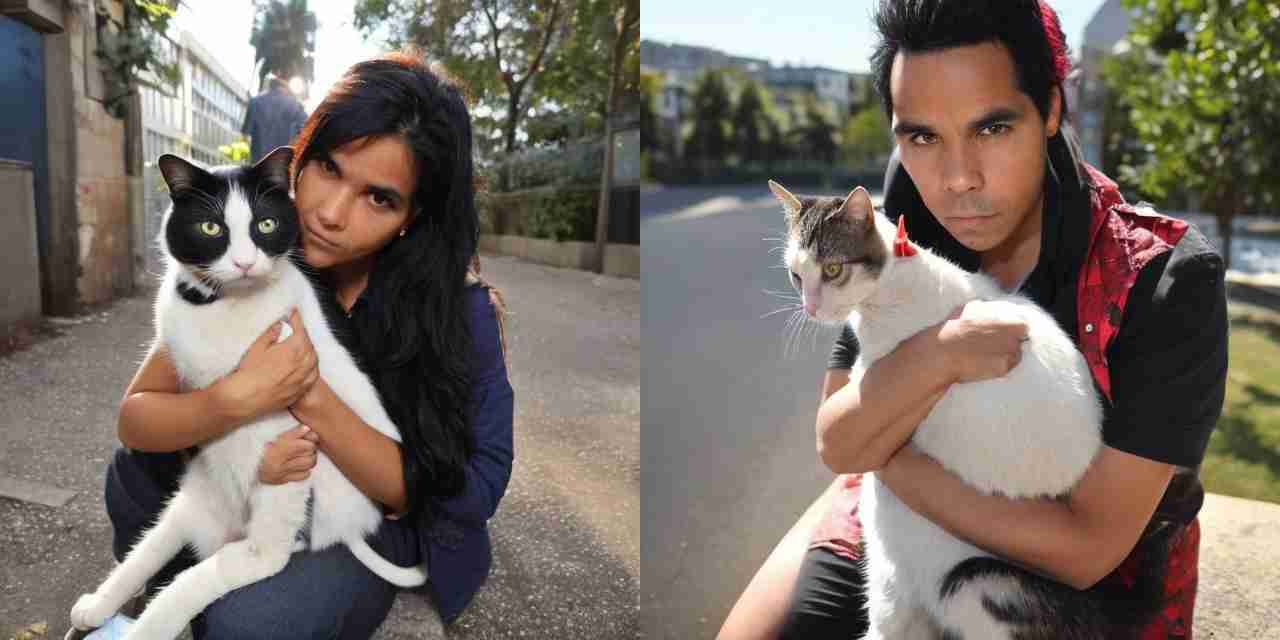

In [21]:
generate_from_weights(unproject(manipulated_loras["Black_Hair"][0]), prompt="sks person with a cat")